<a href="https://colab.research.google.com/github/valkova-k/cactus-repo/blob/main/assignment03/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
print(torch.cuda.is_available())

True


In [20]:
!pip install fastai timm


In [21]:
!git clone https://github.com/valkova-k/cactus-repo.git


fatal: destination path 'cactus-repo' already exists and is not an empty directory.


In [22]:
!ls


cactus-repo  model.pkl	sample_data


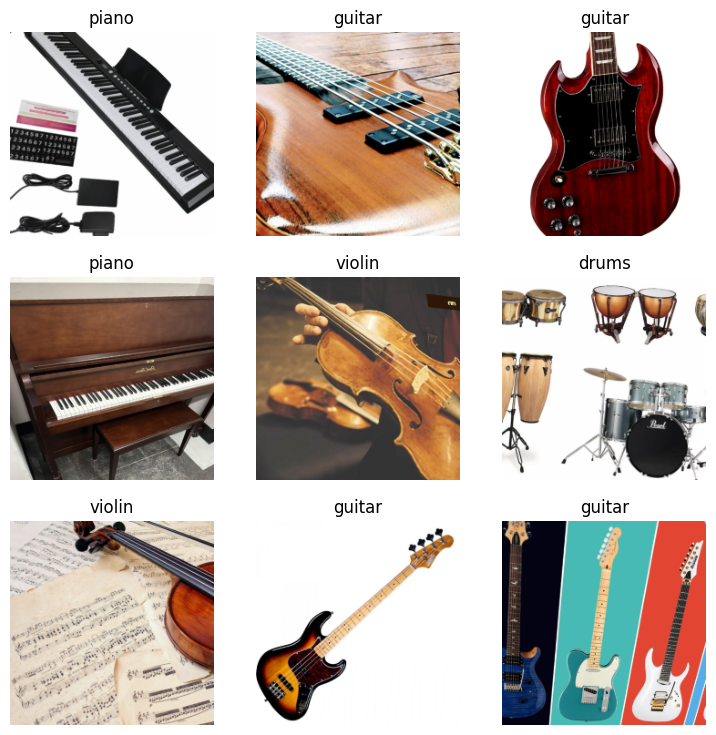

In [23]:
from fastai.vision.all import *
from pathlib import Path

DATASET_ROOT = Path("/content/cactus-repo/dataset_massive")  # ← změň na svou cestu
path_train = DATASET_ROOT/'train'

dls = ImageDataLoaders.from_folder(
    path_train,
    train='.',
    valid_pct=0.2,   # 20 % náhodně dá stranou jako validaci
    seed=42,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    bs=64   # velikost „balíčku“ obrázků, když dojde paměť, zkus 16
)

dls.show_batch(max_n=9)


In [24]:
from timm import create_model

# vezmeme resnet18 = malý model, vhodný na začátek
learn = vision_learner(dls, resnet18, metrics=error_rate)


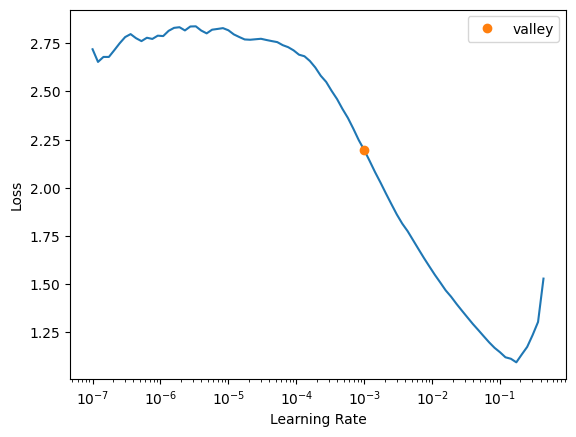

In [25]:
lr = learn.lr_find().valley


In [26]:
learn.fine_tune(5, base_lr=lr)  # číslo = počet epoch (kolikrát projde dataset)


epoch,train_loss,valid_loss,error_rate,time
0,2.087388,0.359323,0.140940,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.506512,0.207351,0.046980,00:32
1,0.377007,0.157072,0.046980,00:29
2,0.273594,0.150880,0.033557,00:31
3,0.209032,0.148668,0.040268,00:31
4,0.169746,0.148411,0.040268,00:31


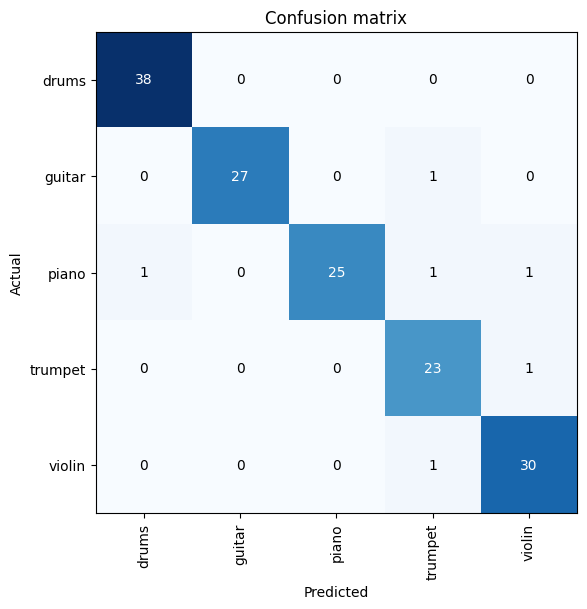

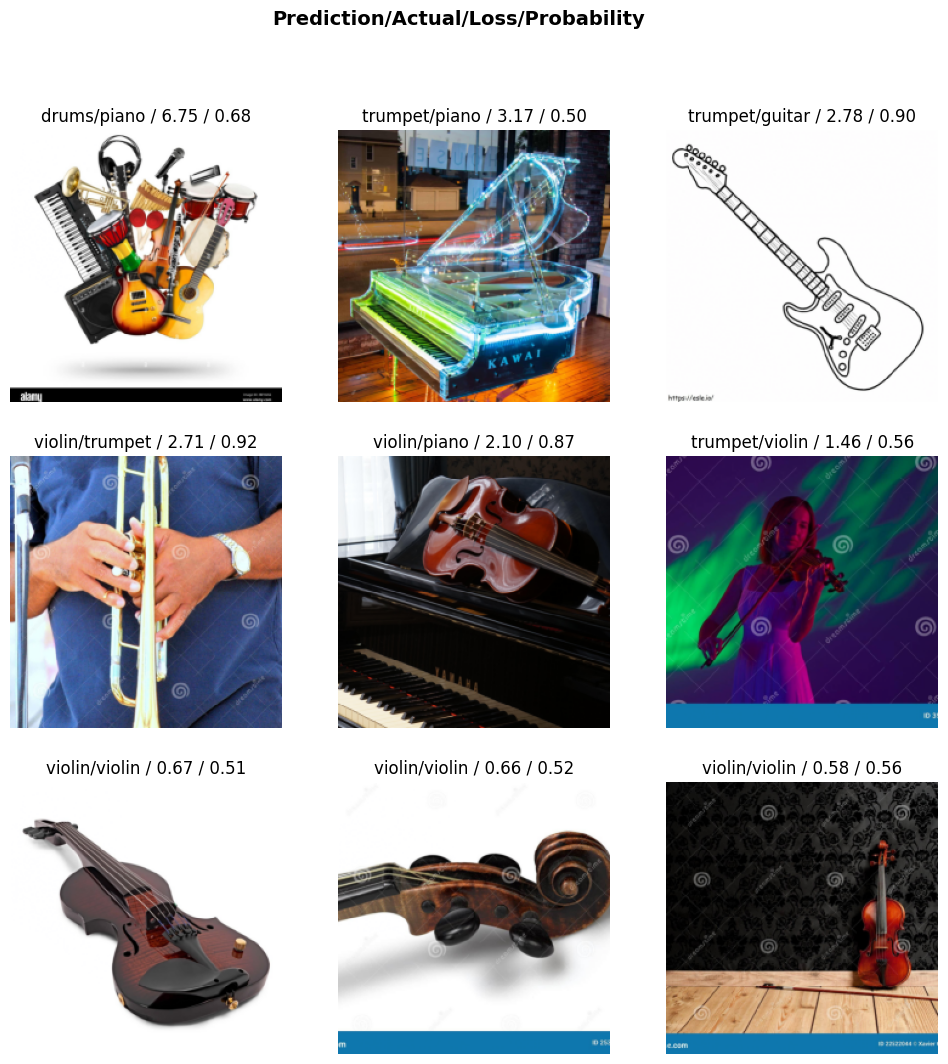

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(12,12))


In [28]:
# hezký widget s obrázky, ale GitHub je nechtěl nahrát, tak jsou zakomentované.
# při odkomentování by vše mělo v pořádku fungovat, aspoň v Colabu

#from fastai.vision.widgets import *


#cleaner = ImageClassifierCleaner(learn)
#cleaner

In [29]:
#for idx in cleaner.delete():
#    cleaner.fns[idx].unlink()
#print("Smazáno:", len(cleaner.delete()), "souborů")


In [30]:
test_path = DATASET_ROOT/'test'
test_dl = learn.dls.test_dl(get_image_files(test_path))
preds, _ = learn.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)

class_names = learn.dls.vocab
pred_names = [class_names[i] for i in pred_labels]
true_names = [p.parent.name for p in test_dl.items]

from statistics import mean
acc = mean(a==p for a,p in zip(true_names, pred_names))
print("Test accuracy:", acc)


Test accuracy: 0.979757085020243


Výběr obrázků z test datasetu

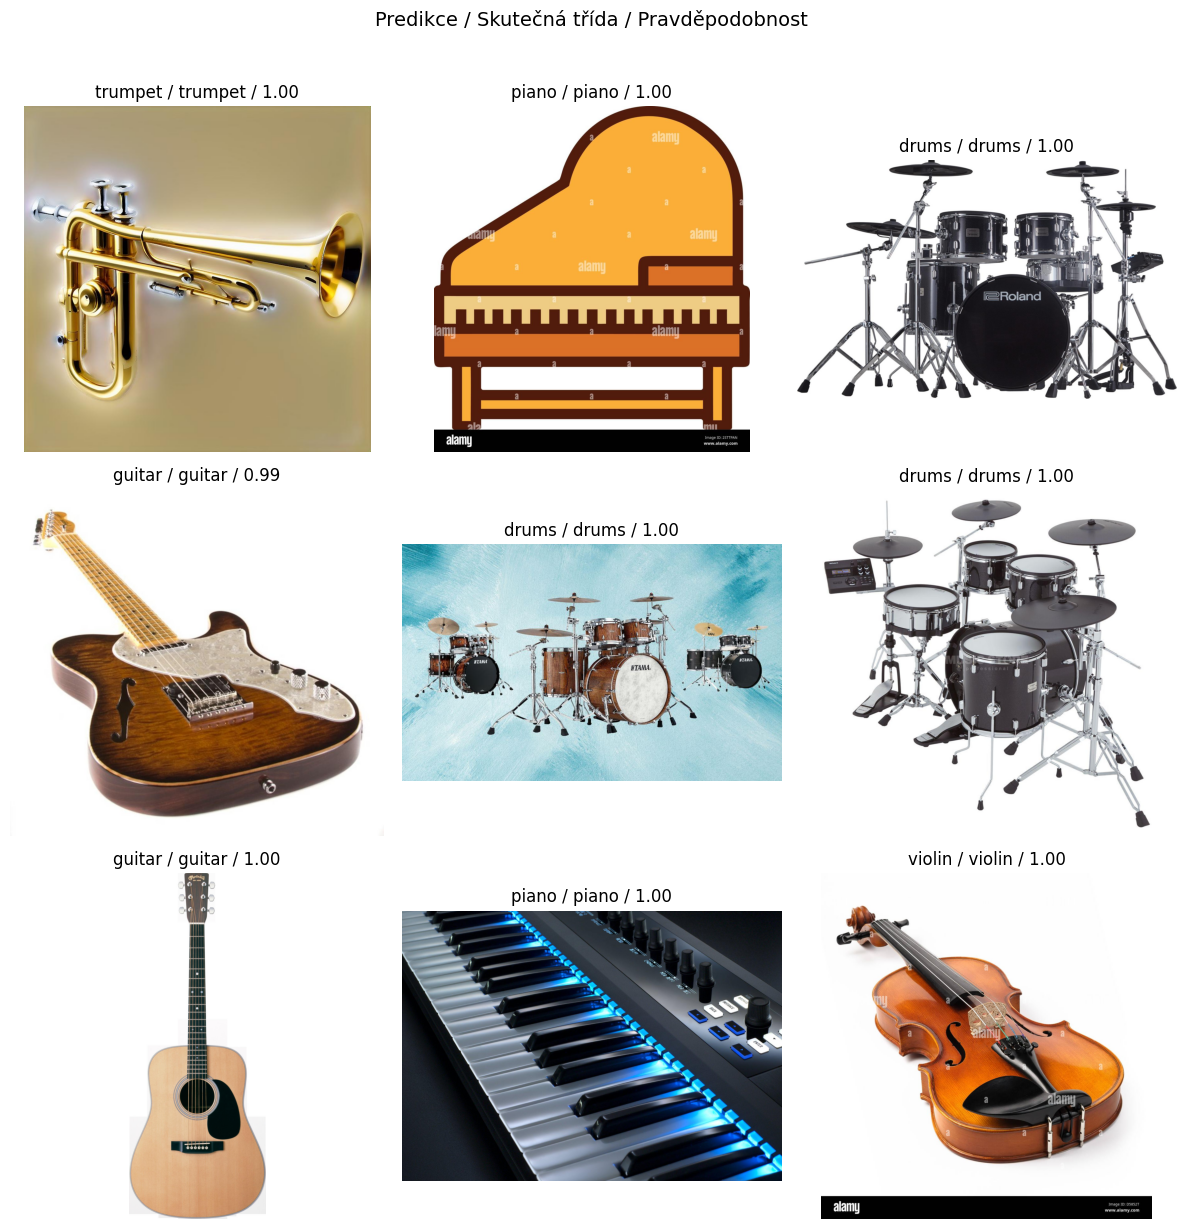

In [31]:
from PIL import Image
import random, math
import matplotlib.pyplot as plt

test_path = DATASET_ROOT/'test'
test_files = get_image_files(test_path)
assert len(test_files) > 0, "V 'test/' nejsou žádné obrázky."

# kolik obrázků ukázat:
K = 9  # změň klidně na 6/12/15...

sample_files = random.sample(list(test_files), k=min(K, len(test_files)))
dl = learn.dls.test_dl(sample_files)
preds, _ = learn.get_preds(dl=dl)
probs, pred_idx = preds.max(dim=1)

classes = learn.dls.vocab
pred_names = [classes[i] for i in pred_idx]
true_names = [p.parent.name for p in sample_files]

cols = 3
rows = math.ceil(len(sample_files)/cols)
plt.figure(figsize=(4*cols, 4*rows))

for i, f in enumerate(sample_files):
    img = Image.open(f).convert("RGB")
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{pred_names[i]} / {true_names[i]} / {probs[i].item():.2f}")

plt.suptitle("Predikce / Skutečná třída / Pravděpodobnost", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [32]:
from pathlib import Path
print("learn.path =", learn.path)
print("cwd        =", Path.cwd())


learn.path = /content/cactus-repo/dataset_massive/train
cwd        = /content


In [33]:
export_path = Path("/content/model.pkl")
learn.export(export_path)
!ls -lh /content/model.pkl

-rw-r--r-- 1 root root 45M Oct  7 13:26 /content/model.pkl


In [34]:
from google.colab import files
files.download("/content/model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>